## Preparation

### Download the optimization support library package

In [1]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 6.9 MB/s eta 0:00:00


### Connect to Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Import Libraries

In [3]:
# Library to support working with data
import numpy as np
import pandas as pd

# Graphing support library
import matplotlib.pyplot as plt

# Data Normalization Support Library
from sklearn.preprocessing import MinMaxScaler

# Library to support building Temporal Convolutional Attention Networks models
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Layer, RepeatVector, concatenate, Reshape, Input, Concatenate, Permute, Multiply, Add, Activation

# Performance metrics calculation support library
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error

# Parameter optimization support library
import optuna

# Support library to ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Support library to load models and data
from keras.utils import custom_object_scope
from tensorflow.keras.models import load_model

## Data preprocessing

### Read data

In [4]:
# Load data
df = pd.read_csv('CTLT.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,30.860001,31.260000,30.240000,30.910000,30.910000,1201700
1,2019-01-03,30.660000,30.660000,29.290001,29.840000,29.840000,1149900
2,2019-01-04,30.049999,31.360001,29.940001,31.080000,31.080000,3530400
3,2019-01-07,31.020000,32.180000,30.850000,32.000000,32.000000,1063400
4,2019-01-08,32.340000,33.060001,32.150002,32.790001,32.790001,1391000
...,...,...,...,...,...,...,...
1114,2023-06-06,37.910000,39.049999,37.580002,38.820000,38.820000,2261700
1115,2023-06-07,39.160000,40.029999,38.250000,39.959999,39.959999,4382500
1116,2023-06-08,39.700001,39.840000,36.750000,39.000000,39.000000,9705500
1117,2023-06-09,39.250000,40.110001,38.480000,38.810001,38.810001,4493800


### Reset index

In [5]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

In [6]:
# Select column 'Close'
df_Close = df[['Close']]
df_Close = df_Close.reset_index(drop=True)

### Data normalization

In [7]:
# Min-max normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Close))

### Data splitting

In [8]:
# Split the data into train, validation, and test dataset in a ratio of 6:2:2
train_size = int(len(data_scaled) * 0.6)
val_size = int(len(data_scaled) * 0.2)
test_size = len(data_scaled) - train_size - val_size

train_data = data_scaled[: train_size]
val_data = data_scaled[train_size : train_size + val_size]
test_data = data_scaled[train_size + val_size :]

## Model training and testing

In [9]:
# Generating data using the window sliding method
def create_dataset(data, window_size):
    windows, targets = [], []
    for i in range(len(data) - window_size):
        windows.append(data[i : (i + window_size), 0])
        targets.append(data[i + window_size, 0])
    return np.array(windows), np.array(targets)

### Building TCANs model

In [10]:
# Constructing sparse attention layer
class AttentionLayer(Layer):
    def __init__(self, attention_dim):
        super(AttentionLayer, self).__init__()
        self.attention_dim = attention_dim

    def build(self, input_shape):
        self.W1 = Dense(units=self.attention_dim, activation='tanh')
        self.W2 = Dense(units=1, activation='linear')
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        score = self.W2(self.W1(x))
        score = Flatten()(score)
        score = Activation('softmax')(score)
        score = RepeatVector(x.shape[-1])(score)
        score = Permute([2, 1])(score)
        return Multiply()([x, score])

    def compute_output_shape(self, input_shape):
        return input_shape

In [11]:
# Build TCAN model
def build_tcan(window_size, input_dim=1, tcn_filters=64, tcn_kernel_size=2, dropout_rate=0.2, attention_dim=16):
    inputs = Input(shape=(window_size, input_dim))
    x = inputs
    x = Conv1D(filters=tcn_filters, kernel_size=tcn_kernel_size, padding='same', activation='relu')(x)
    x = SpatialDropout1D(rate=dropout_rate)(x)
    x = Conv1D(filters=tcn_filters, kernel_size=tcn_kernel_size, padding='same', activation='relu')(x)
    x = SpatialDropout1D(rate=dropout_rate)(x)

    # Additive Attention
    att = AttentionLayer(attention_dim)(x)
    max_pool_att = GlobalMaxPooling1D()(att)
    max_pool_x = GlobalMaxPooling1D()(x)
    x = concatenate([max_pool_att, max_pool_x])

    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mean_absolute_error', optimizer=optimizer)

    return model

### Learning process with combined parameter optimization

In [12]:
# Initialization of optimization parameters
best_mse = float('inf')
best_model = None
best_window_size = None
best_train_windows = None
best_train_targets = None
best_test_windows = None
best_test_targets = None
best_val_windows = None
best_val_targets = None
best_y_pred = None
best_mape = np.inf
best_rmse = np.inf
best_msle = np.inf

In [13]:
# Define the objective function for Optuna optimization
def objective(trial):
  global best_mse, best_model, best_window_size, best_train_windows
  global best_train_targets, best_test_windows, best_test_targets, best_val_windows
  global best_val_targets, best_y_pred, best_mape, best_rmse, best_msle

  # Define the search space for hyperparameters
  window_size = trial.suggest_int("window_size", 10, 100)
  tcn_filters = trial.suggest_int("tcn_filters", 32, 128)
  tcn_kernel_size = trial.suggest_int("tcn_kernel_size", 2, 5)
  dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
  attention_dim = trial.suggest_int("attention_dim", 8, 32)

  # Build the TCAN model with the suggested hyperparameters
  model = build_tcan(window_size,
                     tcn_filters = tcn_filters,
                     tcn_kernel_size = tcn_kernel_size,
                     dropout_rate = dropout_rate,
                     attention_dim = attention_dim)

  train_windows, train_targets = create_dataset(train_data, window_size)
  test_windows, test_targets = create_dataset(test_data, window_size)
  val_windows, val_targets = create_dataset(val_data, window_size)

  # Train the model
  early_stop = EarlyStopping(monitor='val_loss', patience=5)
  model.fit(train_windows, train_targets,
            epochs=50, batch_size=32,
            validation_data=(val_windows, val_targets),
            shuffle=False, callbacks=[early_stop], verbose=0)

  # Testing the model on Test dataset
  y_pred = model.predict(test_windows)

  # Evaluate on MAPE, RMSE, MSLE
  temp_test_targets = test_targets
  temp_test_targets = scaler.inverse_transform(temp_test_targets.reshape(-1, 1))
  y_pred = scaler.inverse_transform(y_pred)

  mse = mean_squared_error(temp_test_targets, y_pred)
  rmse = np.sqrt(mse)
  mape = mean_absolute_percentage_error(temp_test_targets, y_pred)
  msle = mean_squared_log_error(temp_test_targets, y_pred)

  # Save the best model and related information
  if mse < best_mse or best_mse is None:
    best_model = model
    best_window_size = window_size
    best_y_pred = y_pred
    best_train_windows = train_windows
    best_train_targets = train_targets
    best_test_windows = test_windows
    best_test_targets = test_targets
    best_val_windows = val_windows
    best_val_targets = val_targets
    best_rmse = rmse
    best_mape = mape
    best_msle = msle
    best_mse = mse

  return mse

In [14]:
# Define the search space for the hyperparameters
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2023-06-14 15:03:11,938] A new study created in memory with name: no-name-f35a1816-6e53-40d7-98da-690bee69815a


5/5 [==============================] - 0s 12ms/step


[I 2023-06-14 15:03:36,867] Trial 0 finished with value: 461.16203627780095 and parameters: {'window_size': 83, 'tcn_filters': 50, 'tcn_kernel_size': 5, 'dropout_rate': 0.37791209551704386, 'attention_dim': 16}. Best is trial 0 with value: 461.16203627780095.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 15:03:41,517] Trial 1 finished with value: 152.8357987023346 and parameters: {'window_size': 30, 'tcn_filters': 69, 'tcn_kernel_size': 3, 'dropout_rate': 0.4061442722488008, 'attention_dim': 31}. Best is trial 1 with value: 152.8357987023346.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 15:03:55,894] Trial 2 finished with value: 86.94604797041565 and parameters: {'window_size': 68, 'tcn_filters': 84, 'tcn_kernel_size': 4, 'dropout_rate': 0.11385367788591205, 'attention_dim': 17}. Best is trial 2 with value: 86.94604797041565.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 15:04:03,354] Trial 3 finished with value: 27.283957338491863 and parameters: {'window_size': 14, 'tcn_filters': 124, 'tcn_kernel_size': 2, 'dropout_rate': 0.23554057180386337, 'attention_dim': 23}. Best is trial 3 with value: 27.283957338491863.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 15:04:11,371] Trial 4 finished with value: 164.61806317302572 and parameters: {'window_size': 46, 'tcn_filters': 63, 'tcn_kernel_size': 5, 'dropout_rate': 0.47085620240261117, 'attention_dim': 30}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 15:04:24,077] Trial 5 finished with value: 109.67953517563548 and parameters: {'window_size': 28, 'tcn_filters': 73, 'tcn_kernel_size': 3, 'dropout_rate': 0.30893600392238174, 'attention_dim': 12}. Best is trial 3 with value: 27.283957338491863.


5/5 [==============================] - 0s 5ms/step


[I 2023-06-14 15:04:34,873] Trial 6 finished with value: 218.3711322822123 and parameters: {'window_size': 72, 'tcn_filters': 55, 'tcn_kernel_size': 4, 'dropout_rate': 0.38432614694618583, 'attention_dim': 10}. Best is trial 3 with value: 27.283957338491863.


5/5 [==============================] - 0s 5ms/step


[I 2023-06-14 15:04:41,880] Trial 7 finished with value: 349.5350042068426 and parameters: {'window_size': 76, 'tcn_filters': 42, 'tcn_kernel_size': 2, 'dropout_rate': 0.4290095495297652, 'attention_dim': 19}. Best is trial 3 with value: 27.283957338491863.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 15:04:52,062] Trial 8 finished with value: 78.34247168581705 and parameters: {'window_size': 34, 'tcn_filters': 113, 'tcn_kernel_size': 3, 'dropout_rate': 0.3879197771347974, 'attention_dim': 27}. Best is trial 3 with value: 27.283957338491863.


4/4 [==============================] - 0s 11ms/step


[I 2023-06-14 15:05:04,785] Trial 9 finished with value: 269.7009342078718 and parameters: {'window_size': 99, 'tcn_filters': 98, 'tcn_kernel_size': 4, 'dropout_rate': 0.49853096942008746, 'attention_dim': 26}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 15:05:10,497] Trial 10 finished with value: 31.919440286597805 and parameters: {'window_size': 13, 'tcn_filters': 120, 'tcn_kernel_size': 2, 'dropout_rate': 0.20276428446363298, 'attention_dim': 24}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 15:05:17,929] Trial 11 finished with value: 49.67241322839741 and parameters: {'window_size': 10, 'tcn_filters': 127, 'tcn_kernel_size': 2, 'dropout_rate': 0.20113199672131576, 'attention_dim': 23}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 15:05:25,744] Trial 12 finished with value: 34.57236462099951 and parameters: {'window_size': 10, 'tcn_filters': 128, 'tcn_kernel_size': 2, 'dropout_rate': 0.2349785865722597, 'attention_dim': 23}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 15:05:38,609] Trial 13 finished with value: 73.22861459472117 and parameters: {'window_size': 21, 'tcn_filters': 106, 'tcn_kernel_size': 2, 'dropout_rate': 0.22334327981410795, 'attention_dim': 23}. Best is trial 3 with value: 27.283957338491863.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 15:05:48,732] Trial 14 finished with value: 254.73466335066925 and parameters: {'window_size': 47, 'tcn_filters': 90, 'tcn_kernel_size': 2, 'dropout_rate': 0.1646854729310988, 'attention_dim': 27}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 15:05:54,802] Trial 15 finished with value: 113.42877100472717 and parameters: {'window_size': 20, 'tcn_filters': 112, 'tcn_kernel_size': 3, 'dropout_rate': 0.2807547710033202, 'attention_dim': 21}. Best is trial 3 with value: 27.283957338491863.


6/6 [==============================] - 0s 7ms/step


[I 2023-06-14 15:06:08,596] Trial 16 finished with value: 129.2820084997612 and parameters: {'window_size': 42, 'tcn_filters': 118, 'tcn_kernel_size': 2, 'dropout_rate': 0.15344104917745044, 'attention_dim': 14}. Best is trial 3 with value: 27.283957338491863.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 15:06:31,436] Trial 17 finished with value: 177.65515179404193 and parameters: {'window_size': 57, 'tcn_filters': 99, 'tcn_kernel_size': 3, 'dropout_rate': 0.2758562154548817, 'attention_dim': 20}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 7ms/step


[I 2023-06-14 15:06:38,659] Trial 18 finished with value: 70.8511297523794 and parameters: {'window_size': 19, 'tcn_filters': 123, 'tcn_kernel_size': 2, 'dropout_rate': 0.10051309161477412, 'attention_dim': 25}. Best is trial 3 with value: 27.283957338491863.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 15:06:55,434] Trial 19 finished with value: 171.70895517591745 and parameters: {'window_size': 60, 'tcn_filters': 103, 'tcn_kernel_size': 3, 'dropout_rate': 0.3380208352213498, 'attention_dim': 29}. Best is trial 3 with value: 27.283957338491863.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 15:07:10,276] Trial 20 finished with value: 175.69083405588583 and parameters: {'window_size': 37, 'tcn_filters': 90, 'tcn_kernel_size': 2, 'dropout_rate': 0.25123548544210805, 'attention_dim': 8}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 15:07:14,981] Trial 21 finished with value: 47.775916294406265 and parameters: {'window_size': 15, 'tcn_filters': 125, 'tcn_kernel_size': 2, 'dropout_rate': 0.232347676138841, 'attention_dim': 23}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 6ms/step


[I 2023-06-14 15:07:19,708] Trial 22 finished with value: 89.60212105712891 and parameters: {'window_size': 10, 'tcn_filters': 116, 'tcn_kernel_size': 2, 'dropout_rate': 0.1810420047199054, 'attention_dim': 24}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 15:07:32,628] Trial 23 finished with value: 86.94925389512947 and parameters: {'window_size': 26, 'tcn_filters': 128, 'tcn_kernel_size': 2, 'dropout_rate': 0.2096791789779443, 'attention_dim': 21}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 15:07:39,948] Trial 24 finished with value: 92.67901658993536 and parameters: {'window_size': 10, 'tcn_filters': 109, 'tcn_kernel_size': 3, 'dropout_rate': 0.24754479426977913, 'attention_dim': 18}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 15:07:46,304] Trial 25 finished with value: 52.55623117013303 and parameters: {'window_size': 24, 'tcn_filters': 120, 'tcn_kernel_size': 2, 'dropout_rate': 0.1943188204402881, 'attention_dim': 29}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 15:07:52,918] Trial 26 finished with value: 40.35681600029479 and parameters: {'window_size': 16, 'tcn_filters': 119, 'tcn_kernel_size': 3, 'dropout_rate': 0.25191303702541523, 'attention_dim': 22}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 15:07:57,417] Trial 27 finished with value: 66.17675339792505 and parameters: {'window_size': 16, 'tcn_filters': 33, 'tcn_kernel_size': 2, 'dropout_rate': 0.15437208496342103, 'attention_dim': 25}. Best is trial 3 with value: 27.283957338491863.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 15:08:10,464] Trial 28 finished with value: 94.07279668914971 and parameters: {'window_size': 36, 'tcn_filters': 94, 'tcn_kernel_size': 4, 'dropout_rate': 0.22419395069617534, 'attention_dim': 28}. Best is trial 3 with value: 27.283957338491863.


5/5 [==============================] - 0s 19ms/step


[I 2023-06-14 15:08:33,227] Trial 29 finished with value: 176.0336978222849 and parameters: {'window_size': 85, 'tcn_filters': 107, 'tcn_kernel_size': 5, 'dropout_rate': 0.3344777693647947, 'attention_dim': 16}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 15:08:45,872] Trial 30 finished with value: 139.19956547571795 and parameters: {'window_size': 30, 'tcn_filters': 79, 'tcn_kernel_size': 2, 'dropout_rate': 0.1828236922538732, 'attention_dim': 32}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 15:08:53,067] Trial 31 finished with value: 72.54879747836581 and parameters: {'window_size': 15, 'tcn_filters': 119, 'tcn_kernel_size': 3, 'dropout_rate': 0.2553362657746947, 'attention_dim': 21}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 7ms/step


[I 2023-06-14 15:09:02,222] Trial 32 finished with value: 109.21688091174909 and parameters: {'window_size': 16, 'tcn_filters': 128, 'tcn_kernel_size': 3, 'dropout_rate': 0.27644366699805833, 'attention_dim': 22}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 6ms/step


[I 2023-06-14 15:09:14,500] Trial 33 finished with value: 95.12063227938272 and parameters: {'window_size': 25, 'tcn_filters': 114, 'tcn_kernel_size': 2, 'dropout_rate': 0.23018425560353134, 'attention_dim': 25}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 15:09:21,832] Trial 34 finished with value: 78.24596376191042 and parameters: {'window_size': 13, 'tcn_filters': 121, 'tcn_kernel_size': 3, 'dropout_rate': 0.20771416384895083, 'attention_dim': 19}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 15:09:34,066] Trial 35 finished with value: 47.16630677142507 and parameters: {'window_size': 20, 'tcn_filters': 122, 'tcn_kernel_size': 4, 'dropout_rate': 0.3022551884341706, 'attention_dim': 22}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 15:09:47,266] Trial 36 finished with value: 53.80026276735146 and parameters: {'window_size': 32, 'tcn_filters': 103, 'tcn_kernel_size': 3, 'dropout_rate': 0.13236501637868264, 'attention_dim': 24}. Best is trial 3 with value: 27.283957338491863.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 15:10:00,026] Trial 37 finished with value: 118.71278782328788 and parameters: {'window_size': 41, 'tcn_filters': 111, 'tcn_kernel_size': 2, 'dropout_rate': 0.2631034526086188, 'attention_dim': 17}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 15:10:04,520] Trial 38 finished with value: 75.09822777830482 and parameters: {'window_size': 27, 'tcn_filters': 65, 'tcn_kernel_size': 5, 'dropout_rate': 0.2919723121480212, 'attention_dim': 19}. Best is trial 3 with value: 27.283957338491863.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 15:10:16,751] Trial 39 finished with value: 291.4580761010848 and parameters: {'window_size': 52, 'tcn_filters': 80, 'tcn_kernel_size': 3, 'dropout_rate': 0.24595756411672762, 'attention_dim': 26}. Best is trial 3 with value: 27.283957338491863.


5/5 [==============================] - 0s 5ms/step


[I 2023-06-14 15:10:30,284] Trial 40 finished with value: 288.09198419661743 and parameters: {'window_size': 65, 'tcn_filters': 53, 'tcn_kernel_size': 2, 'dropout_rate': 0.18858764340084486, 'attention_dim': 15}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 8ms/step


[I 2023-06-14 15:10:37,561] Trial 41 finished with value: 147.24303010931402 and parameters: {'window_size': 20, 'tcn_filters': 124, 'tcn_kernel_size': 4, 'dropout_rate': 0.308157918735755, 'attention_dim': 22}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 6ms/step


[I 2023-06-14 15:10:46,283] Trial 42 finished with value: 39.59163652503586 and parameters: {'window_size': 22, 'tcn_filters': 116, 'tcn_kernel_size': 4, 'dropout_rate': 0.30402932578655417, 'attention_dim': 22}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 15:10:53,371] Trial 43 finished with value: 73.29320398292857 and parameters: {'window_size': 10, 'tcn_filters': 116, 'tcn_kernel_size': 4, 'dropout_rate': 0.21702626708651873, 'attention_dim': 24}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 7ms/step


[I 2023-06-14 15:11:06,992] Trial 44 finished with value: 63.47004768287855 and parameters: {'window_size': 24, 'tcn_filters': 114, 'tcn_kernel_size': 4, 'dropout_rate': 0.23278279351558173, 'attention_dim': 20}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 15:11:14,539] Trial 45 finished with value: 281.7605583891526 and parameters: {'window_size': 14, 'tcn_filters': 124, 'tcn_kernel_size': 4, 'dropout_rate': 0.2652493994732601, 'attention_dim': 27}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 15:11:23,911] Trial 46 finished with value: 67.71444258531534 and parameters: {'window_size': 18, 'tcn_filters': 103, 'tcn_kernel_size': 5, 'dropout_rate': 0.32099193998693193, 'attention_dim': 23}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 15:11:31,034] Trial 47 finished with value: 52.720983527714864 and parameters: {'window_size': 23, 'tcn_filters': 118, 'tcn_kernel_size': 2, 'dropout_rate': 0.2891697272898245, 'attention_dim': 26}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 15:11:41,682] Trial 48 finished with value: 61.51521461044276 and parameters: {'window_size': 29, 'tcn_filters': 110, 'tcn_kernel_size': 3, 'dropout_rate': 0.2657553025693614, 'attention_dim': 21}. Best is trial 3 with value: 27.283957338491863.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 15:12:04,096] Trial 49 finished with value: 360.0270499399946 and parameters: {'window_size': 83, 'tcn_filters': 97, 'tcn_kernel_size': 2, 'dropout_rate': 0.2051894326304772, 'attention_dim': 20}. Best is trial 3 with value: 27.283957338491863.


4/4 [==============================] - 0s 14ms/step


[I 2023-06-14 15:12:23,476] Trial 50 finished with value: 220.6601316861024 and parameters: {'window_size': 100, 'tcn_filters': 128, 'tcn_kernel_size': 4, 'dropout_rate': 0.23831328593275414, 'attention_dim': 18}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 9ms/step


[I 2023-06-14 15:12:30,631] Trial 51 finished with value: 93.65899414299493 and parameters: {'window_size': 20, 'tcn_filters': 121, 'tcn_kernel_size': 4, 'dropout_rate': 0.2883414294057152, 'attention_dim': 22}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 1s 5ms/step


[I 2023-06-14 15:12:37,535] Trial 52 finished with value: 65.42888432249462 and parameters: {'window_size': 13, 'tcn_filters': 123, 'tcn_kernel_size': 4, 'dropout_rate': 0.3029458512570042, 'attention_dim': 22}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 7ms/step


[I 2023-06-14 15:12:45,078] Trial 53 finished with value: 33.18428459921662 and parameters: {'window_size': 17, 'tcn_filters': 117, 'tcn_kernel_size': 4, 'dropout_rate': 0.27000454541995644, 'attention_dim': 24}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 15:12:52,558] Trial 54 finished with value: 193.8111404046717 and parameters: {'window_size': 17, 'tcn_filters': 116, 'tcn_kernel_size': 4, 'dropout_rate': 0.24633565354432577, 'attention_dim': 24}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 15:13:04,788] Trial 55 finished with value: 38.149395372156455 and parameters: {'window_size': 12, 'tcn_filters': 106, 'tcn_kernel_size': 2, 'dropout_rate': 0.21641963721608257, 'attention_dim': 23}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 15:13:11,175] Trial 56 finished with value: 34.05583057456326 and parameters: {'window_size': 12, 'tcn_filters': 108, 'tcn_kernel_size': 2, 'dropout_rate': 0.216424498607981, 'attention_dim': 25}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 15:13:18,984] Trial 57 finished with value: 29.15224803384516 and parameters: {'window_size': 10, 'tcn_filters': 105, 'tcn_kernel_size': 2, 'dropout_rate': 0.17166751646290845, 'attention_dim': 27}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 15:13:26,105] Trial 58 finished with value: 32.565961209248606 and parameters: {'window_size': 10, 'tcn_filters': 86, 'tcn_kernel_size': 2, 'dropout_rate': 0.17509552936337977, 'attention_dim': 28}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 15:13:33,942] Trial 59 finished with value: 35.36327355804289 and parameters: {'window_size': 10, 'tcn_filters': 71, 'tcn_kernel_size': 2, 'dropout_rate': 0.1726217589870198, 'attention_dim': 30}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 15:13:41,085] Trial 60 finished with value: 67.94939775660902 and parameters: {'window_size': 13, 'tcn_filters': 87, 'tcn_kernel_size': 2, 'dropout_rate': 0.16999884593414225, 'attention_dim': 28}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 6ms/step


[I 2023-06-14 15:13:47,792] Trial 61 finished with value: 48.373941969256975 and parameters: {'window_size': 17, 'tcn_filters': 99, 'tcn_kernel_size': 2, 'dropout_rate': 0.2020107276861659, 'attention_dim': 28}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 15:13:55,115] Trial 62 finished with value: 38.47112553586898 and parameters: {'window_size': 10, 'tcn_filters': 93, 'tcn_kernel_size': 2, 'dropout_rate': 0.18722716490835586, 'attention_dim': 26}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 15:14:02,440] Trial 63 finished with value: 39.19218823193775 and parameters: {'window_size': 13, 'tcn_filters': 84, 'tcn_kernel_size': 2, 'dropout_rate': 0.1982019230319563, 'attention_dim': 25}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 6ms/step


[I 2023-06-14 15:14:09,713] Trial 64 finished with value: 44.49107215305159 and parameters: {'window_size': 18, 'tcn_filters': 112, 'tcn_kernel_size': 2, 'dropout_rate': 0.22274249625122683, 'attention_dim': 27}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 15:14:17,264] Trial 65 finished with value: 73.79807643744601 and parameters: {'window_size': 22, 'tcn_filters': 126, 'tcn_kernel_size': 2, 'dropout_rate': 0.15489270378923667, 'attention_dim': 30}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 15:14:29,392] Trial 66 finished with value: 40.74853533908154 and parameters: {'window_size': 15, 'tcn_filters': 107, 'tcn_kernel_size': 2, 'dropout_rate': 0.13817258648649589, 'attention_dim': 29}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 15:14:35,029] Trial 67 finished with value: 54.56239899106971 and parameters: {'window_size': 10, 'tcn_filters': 58, 'tcn_kernel_size': 2, 'dropout_rate': 0.18162684022962203, 'attention_dim': 25}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 15:14:42,895] Trial 68 finished with value: 62.97083178587368 and parameters: {'window_size': 27, 'tcn_filters': 76, 'tcn_kernel_size': 2, 'dropout_rate': 0.21333261064330356, 'attention_dim': 31}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 15:14:48,792] Trial 69 finished with value: 50.757680384132286 and parameters: {'window_size': 18, 'tcn_filters': 100, 'tcn_kernel_size': 2, 'dropout_rate': 0.1983295246232357, 'attention_dim': 27}. Best is trial 3 with value: 27.283957338491863.


5/5 [==============================] - 0s 11ms/step


[I 2023-06-14 15:15:12,035] Trial 70 finished with value: 220.26512930149238 and parameters: {'window_size': 95, 'tcn_filters': 109, 'tcn_kernel_size': 2, 'dropout_rate': 0.23676668793244532, 'attention_dim': 26}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 6ms/step


[I 2023-06-14 15:15:17,694] Trial 71 finished with value: 39.541452577679806 and parameters: {'window_size': 13, 'tcn_filters': 74, 'tcn_kernel_size': 2, 'dropout_rate': 0.17116200203902066, 'attention_dim': 30}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 15:15:23,061] Trial 72 finished with value: 30.04732342882011 and parameters: {'window_size': 10, 'tcn_filters': 68, 'tcn_kernel_size': 2, 'dropout_rate': 0.17866406826804423, 'attention_dim': 24}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 15:15:27,073] Trial 73 finished with value: 34.68403594349836 and parameters: {'window_size': 12, 'tcn_filters': 65, 'tcn_kernel_size': 2, 'dropout_rate': 0.19238103869814827, 'attention_dim': 24}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 15:15:32,042] Trial 74 finished with value: 35.02915594720423 and parameters: {'window_size': 15, 'tcn_filters': 44, 'tcn_kernel_size': 2, 'dropout_rate': 0.22545327143715269, 'attention_dim': 25}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 15:15:45,083] Trial 75 finished with value: 79.30695498867225 and parameters: {'window_size': 22, 'tcn_filters': 69, 'tcn_kernel_size': 2, 'dropout_rate': 0.21109572621566722, 'attention_dim': 23}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 15:15:51,259] Trial 76 finished with value: 42.126804860337614 and parameters: {'window_size': 16, 'tcn_filters': 60, 'tcn_kernel_size': 2, 'dropout_rate': 0.16254929564334233, 'attention_dim': 26}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 7ms/step


[I 2023-06-14 15:15:57,855] Trial 77 finished with value: 146.6437320773195 and parameters: {'window_size': 32, 'tcn_filters': 118, 'tcn_kernel_size': 2, 'dropout_rate': 0.18659757018424197, 'attention_dim': 24}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 15:16:05,370] Trial 78 finished with value: 56.27506890785406 and parameters: {'window_size': 19, 'tcn_filters': 105, 'tcn_kernel_size': 3, 'dropout_rate': 0.1759243540829277, 'attention_dim': 28}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 15:16:12,609] Trial 79 finished with value: 75.85962557904406 and parameters: {'window_size': 12, 'tcn_filters': 126, 'tcn_kernel_size': 2, 'dropout_rate': 0.2230723843227509, 'attention_dim': 12}. Best is trial 3 with value: 27.283957338491863.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 15:16:25,297] Trial 80 finished with value: 157.13877987486745 and parameters: {'window_size': 48, 'tcn_filters': 114, 'tcn_kernel_size': 2, 'dropout_rate': 0.23788196252571756, 'attention_dim': 23}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 15:16:30,125] Trial 81 finished with value: 45.45304901227257 and parameters: {'window_size': 12, 'tcn_filters': 64, 'tcn_kernel_size': 2, 'dropout_rate': 0.1939168042595445, 'attention_dim': 24}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 15:16:35,278] Trial 82 finished with value: 42.37677941215751 and parameters: {'window_size': 10, 'tcn_filters': 68, 'tcn_kernel_size': 2, 'dropout_rate': 0.19372504636652352, 'attention_dim': 24}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 15:16:39,831] Trial 83 finished with value: 57.17216746137352 and parameters: {'window_size': 15, 'tcn_filters': 61, 'tcn_kernel_size': 2, 'dropout_rate': 0.2083349340474829, 'attention_dim': 25}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 15:16:44,958] Trial 84 finished with value: 36.731966633082024 and parameters: {'window_size': 12, 'tcn_filters': 66, 'tcn_kernel_size': 2, 'dropout_rate': 0.16273387578207538, 'attention_dim': 27}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 15:16:49,559] Trial 85 finished with value: 55.07319727135097 and parameters: {'window_size': 19, 'tcn_filters': 55, 'tcn_kernel_size': 2, 'dropout_rate': 0.25860169057398946, 'attention_dim': 21}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 15:17:03,159] Trial 86 finished with value: 189.49771415622823 and parameters: {'window_size': 24, 'tcn_filters': 120, 'tcn_kernel_size': 2, 'dropout_rate': 0.18057833230079612, 'attention_dim': 24}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 15:17:07,168] Trial 87 finished with value: 61.220907665375506 and parameters: {'window_size': 15, 'tcn_filters': 76, 'tcn_kernel_size': 2, 'dropout_rate': 0.20396098887850986, 'attention_dim': 26}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 15:17:14,306] Trial 88 finished with value: 51.818584333102315 and parameters: {'window_size': 12, 'tcn_filters': 84, 'tcn_kernel_size': 3, 'dropout_rate': 0.14581105411011516, 'attention_dim': 23}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 7ms/step


[I 2023-06-14 15:17:26,706] Trial 89 finished with value: 69.3310645164646 and parameters: {'window_size': 21, 'tcn_filters': 123, 'tcn_kernel_size': 2, 'dropout_rate': 0.2169923045863991, 'attention_dim': 25}. Best is trial 3 with value: 27.283957338491863.


5/5 [==============================] - 0s 6ms/step


[I 2023-06-14 15:17:49,363] Trial 90 finished with value: 373.6838790204017 and parameters: {'window_size': 68, 'tcn_filters': 95, 'tcn_kernel_size': 2, 'dropout_rate': 0.19069409142900398, 'attention_dim': 29}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 15:17:57,374] Trial 91 finished with value: 45.43794194266443 and parameters: {'window_size': 15, 'tcn_filters': 48, 'tcn_kernel_size': 2, 'dropout_rate': 0.22769709275330818, 'attention_dim': 25}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 15:18:02,380] Trial 92 finished with value: 64.54238832572352 and parameters: {'window_size': 17, 'tcn_filters': 52, 'tcn_kernel_size': 2, 'dropout_rate': 0.24849899940425338, 'attention_dim': 23}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 15:18:09,410] Trial 93 finished with value: 36.62351619469422 and parameters: {'window_size': 10, 'tcn_filters': 36, 'tcn_kernel_size': 2, 'dropout_rate': 0.2258600143482859, 'attention_dim': 26}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 15:18:15,261] Trial 94 finished with value: 65.11624770834105 and parameters: {'window_size': 14, 'tcn_filters': 43, 'tcn_kernel_size': 2, 'dropout_rate': 0.24163236769958296, 'attention_dim': 27}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 3ms/step


[I 2023-06-14 15:18:22,455] Trial 95 finished with value: 47.36930807559543 and parameters: {'window_size': 17, 'tcn_filters': 49, 'tcn_kernel_size': 2, 'dropout_rate': 0.2546004639581458, 'attention_dim': 24}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 15:18:29,652] Trial 96 finished with value: 44.10031023168182 and parameters: {'window_size': 12, 'tcn_filters': 46, 'tcn_kernel_size': 2, 'dropout_rate': 0.23105346145170993, 'attention_dim': 25}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 15:18:36,742] Trial 97 finished with value: 52.03099383243936 and parameters: {'window_size': 14, 'tcn_filters': 90, 'tcn_kernel_size': 2, 'dropout_rate': 0.26794502544526, 'attention_dim': 22}. Best is trial 3 with value: 27.283957338491863.


7/7 [==============================] - 0s 6ms/step


[I 2023-06-14 15:18:43,909] Trial 98 finished with value: 117.78056044264504 and parameters: {'window_size': 20, 'tcn_filters': 125, 'tcn_kernel_size': 5, 'dropout_rate': 0.20145988862971906, 'attention_dim': 28}. Best is trial 3 with value: 27.283957338491863.


6/6 [==============================] - 0s 7ms/step


[I 2023-06-14 15:19:05,211] Trial 99 finished with value: 183.78701421212625 and parameters: {'window_size': 60, 'tcn_filters': 116, 'tcn_kernel_size': 2, 'dropout_rate': 0.21929215457151677, 'attention_dim': 25}. Best is trial 3 with value: 27.283957338491863.


In [15]:
# Display the optimal set of parameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'window_size': 14, 'tcn_filters': 124, 'tcn_kernel_size': 2, 'dropout_rate': 0.23554057180386337, 'attention_dim': 23}


In [16]:
# Evaluate the accuracy of test
print(f"MAPE on Test dataset: ", best_mape)
print(f"RMSE on Test dataset: ", best_rmse)
print(f"MSLE on Test dataset: ", best_msle)

MAPE on Test dataset:  0.07283506604923667
RMSE on Test dataset:  5.223404764948994
MSLE on Test dataset:  0.01073622521240748


### Save and Load the best model and related information

In [17]:
# Save the best model and related information
best_model.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_model.h5')

np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_window_size.npy', best_window_size)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_train_windows.npy', best_train_windows)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_train_targets.npy', best_train_targets)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_test_windows.npy', best_test_windows)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_test_targets.npy', best_test_targets)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_val_windows.npy', best_val_windows)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_val_targets.npy', best_val_targets)

np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_y_pred.npy', best_y_pred)

np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_mse.npy', best_mse)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_rmse.npy', best_rmse)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_mape.npy', best_mape)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_msle.npy', best_msle)

In [18]:
# Load the best model and related information
with custom_object_scope({'AttentionLayer': AttentionLayer}):
    loaded_best_model = load_model('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_model.h5')

loaded_best_window_size = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_window_size.npy')
loaded_best_train_windows = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_train_windows.npy')
loaded_best_train_targets = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_train_targets.npy')
loaded_best_test_windows = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_test_windows.npy')
loaded_best_test_targets = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_test_targets.npy')
loaded_best_val_windows = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_val_windows.npy')
loaded_best_val_targets = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_val_targets.npy')

loaded_best_y_pred = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_y_pred.npy')

loaded_best_mse = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_mse.npy').item()
loaded_best_rmse = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_rmse.npy').item()
loaded_best_mape = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_mape.npy').item()
loaded_best_msle = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/CTLT/6:2:2/best_msle.npy').item()

## Predicting the next 30 days

### Preparing the forecast date index

In [19]:
# Get the last date from the current index
last_date = df.index[-1]

# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)

# Create a list of indices starting from the next date for 30 days
index_next_30_days = pd.date_range(start=next_date, periods=30).tolist()

## Prediction process

In [20]:
# Predict the closing price for the next 30 days
last_sequence_days = np.array(data_scaled[-loaded_best_window_size:]).reshape(1, -1, 1)
y_next_30_days = []

for i in range(30):
    # Predict the next day's closing price
    next_day_pred = loaded_best_model.predict(last_sequence_days)

    # Save prediction
    y_next_30_days.append(next_day_pred[0][0])

    # Update data for the next day
    last_sequence_days = np.concatenate([last_sequence_days[:, 1:, :], next_day_pred.reshape(1, 1, 1)], axis=1)

1/1 [==============================] - 0s 29ms/step


In [21]:
print('Predicted closing prices for the next 30 days:')
y_next_30_days = scaler.inverse_transform(np.array(y_next_30_days).reshape(-1, 1))
print(y_next_30_days.flatten())

Predicted closing prices for the next 30 days:
[39.78482  38.687305 38.522987 38.50425  38.501404 38.50099  38.50093
 38.500904 38.5009   38.5009   38.5009   38.5009   38.46685  38.22321
 38.15469  38.13933  38.13701  38.136776 38.13676  38.13676  38.13676
 38.13676  38.13676  38.136765 38.135868 38.12933  38.125263 38.124237
 38.124035 38.124   ]


## Visualization

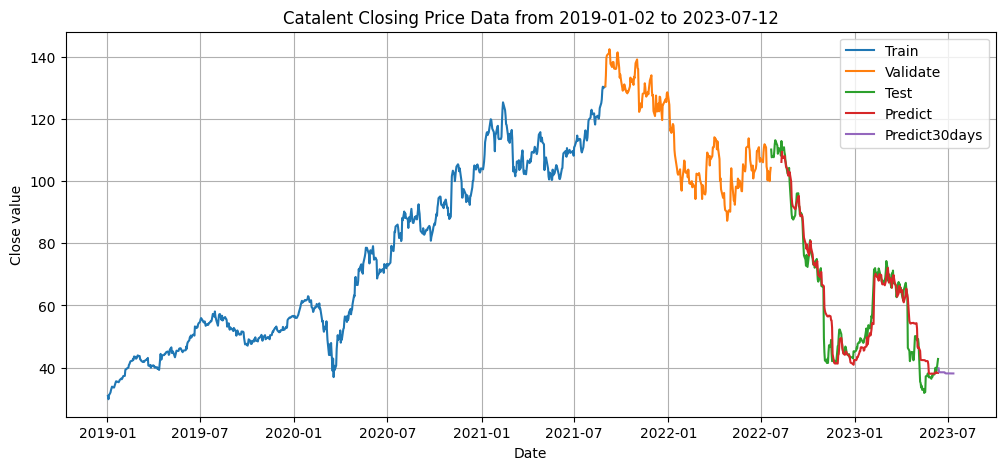

In [22]:
plt.figure(figsize=(12, 5))

plt.plot(df.index[:train_size], scaler.inverse_transform(train_data))

plt.plot(df.index[train_size : train_size + val_size], scaler.inverse_transform(val_data))

plt.plot(df.index[train_size + val_size : ], scaler.inverse_transform(test_data))

plt.plot(df.index[train_size + val_size + best_window_size: ], best_y_pred)

plt.plot(index_next_30_days, y_next_30_days)

plt.legend(['Train', 'Validate', 'Test', 'Predict', 'Predict30days'])

plt.grid()
plt.title(f"Catalent Closing Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_30_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('TCAN_622_CTLT.png')
plt.show()